<a href="https://colab.research.google.com/github/yesiltepe-hidir/NVAE/blob/master/NRAE_Converged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf NVAE

In [ ]:
from train import cleanup
cleanup()

In [1]:
!git clone https://github.com/yesiltepe-hidir/NVAE.git
!pip install tensorboardX

Cloning into 'NVAE'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 151 (delta 46), reused 24 (delta 13), pack-reused 70
Receiving objects: 100% (151/151), 11.55 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 6.8 MB/s 


In [ ]:
!git clone https://github.com/NVlabs/NVAE.git

Cloning into 'NVAE'...
remote: Enumerating objects: 70, done.
remote: Total 70 (delta 0), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (70/70), done.


In [ ]:
# !rm -rf church_outdoor_train_lmdb.zip church_outdoor_val_lmdab.zip church_outdoor_train_lmdb

# # LSUN Church Dataset
# !git clone https://github.com/fyu/lsun.git
# !python3 lsun/download.py -c church_outdoor

# # Unzip 
# !unzip church_outdoor_train_lmdb.zip
# !unzip church_outdoor_val_lmdb.zip

# # Remove
# !rm -rf lsun
# !rm -rf church_outdoor_train_lmdb.zip
# !rm -rf church_outdoor_val_lmdb.zip

In [ ]:
!rm -rf NVAE
!rm -rf NRAE

In [1]:
%cd NRAE 

/content/NRAE


In [2]:
!python3 train.py --dataset mnist --epochs 10 --root /content/NRAE  --data /content/NRAE --save /eval- --batch_size 200 
# !python3 train.py --dataset lsun_church_64 --epochs 5  --root /content/NVAE  --data /content/NVAE --save /eval- --batch_size 32

Experiment dir : /content/NRAE/eval-
starting in debug mode
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
MULT:  1.0
len log norm: 128
len bn: 92
07/27 07:48:16 PM (Elapsed: 00:00:05) args = Namespace(ada_groups=False, arch_instance='res_mbconv', batch_size=200, cont_training=False, data='/content/NRAE', dataset='mnist', distributed=True, embedding_weight=0.0001, epochs=10, fast_adamax=False, global_rank=0, kl_anneal_portion=0.3, kl_const_coeff=0.0001, kl_const_portion=0.0001, l2_weight=0, learning_rate=0.01, learning_rate_min=0.0001, local_rank=0, master_address='127.0.0.1', min_gro

# Train

In [ ]:
# Import libraries
import argparse
import torch
import torch.nn as nn
import numpy as np
import os

import torch.distributed as dist
from torch.multiprocessing import Process
from torch.cuda.amp import autocast, GradScaler

from model import AutoEncoder
from thirdparty.adamax import Adamax
import utils
import datasets
from torchvision import transforms

from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3

import matplotlib.pyplot as plt

In [ ]:
# from google.colab import files
# Get args
PATH = 'eval-/checkpoint.pt'
# files.download(PATH)
checkpoint = torch.load(PATH)
args = checkpoint['args']
checkpoint.keys()

dict_keys(['epoch', 'state_dict', 'optimizer', 'global_step', 'args', 'arch_instance', 'scheduler', 'logits', 'losses', 'z0', 'data', 'grad_scalar'])

In [ ]:
# Create Model
writer = utils.Writer(args.global_rank, args.save)
arch_instance = utils.get_arch_cells(args.arch_instance)
model = AutoEncoder(args, writer, arch_instance)
model = model.cuda()

# Load Model
model.load_state_dict(checkpoint['state_dict'])

# Initialize
os.environ['MASTER_ADDR'] = args.master_address
os.environ['MASTER_PORT'] = '6020'
torch.cuda.set_device(args.local_rank)
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=args.num_process_per_node)

MULT:  1.0
len log norm: 128
len bn: 92


RuntimeError: ignored

In [ ]:
# logits = model.sample(4, 1)
# len(logits)
logits = checkpoint['logits']
logits.size()

torch.Size([200, 1, 32, 32])

In [ ]:
def visualize(n_samples, model, logits, offset=0, size=(400, 400)):
  output = model.decoder_output(logits[offset:offset + n_samples])
  output_img = output.mean
  output_tiled = utils.tile_image(output_img, int(n_samples ** 0.5))

  transform = transforms.ToPILImage()
  img = transform(output_tiled)
  return img.resize(size)

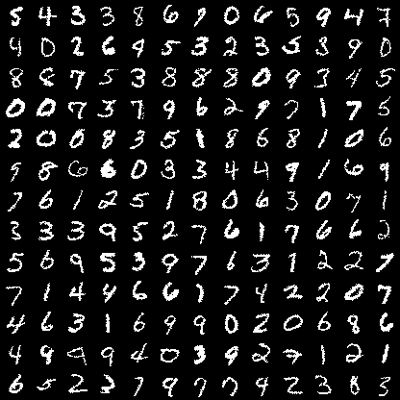

In [ ]:
visualize(169, model, logits)

# NVAE

In [ ]:
%cd ..
!git clone https://github.com/NVlabs/NVAE.git

/
Cloning into 'NVAE'...
remote: Enumerating objects: 70, done.
remote: Total 70 (delta 0), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (70/70), done.


In [ ]:
%cd NVAE

/content/NVAE


In [ ]:
!pwd

/NVAE


In [ ]:
!pip install tensorboardX

In [ ]:
!python3 train.py --dataset mnist --epochs 4 --root /content/NVAE  --data /content/NVAE --save /eval- --batch_size 200
# !python3 train.py --dataset lsun_church_64 --epochs 5  --root /content/NVAE  --data /content/NRAE --save /eval- --batch_size 32

Experiment dir : /content/NVAE/eval-/eval-
starting in debug mode
100% 9912422/9912422 [00:00<00:00, 97836482.90it/s]
Extracting /content/NVAE/MNIST/raw/train-images-idx3-ubyte.gz to /content/NVAE/MNIST/raw

100% 28881/28881 [00:00<00:00, 139879554.07it/s]
Extracting /content/NVAE/MNIST/raw/train-labels-idx1-ubyte.gz to /content/NVAE/MNIST/raw

100% 1648877/1648877 [00:00<00:00, 38908406.26it/s]
Extracting /content/NVAE/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/NVAE/MNIST/raw

100% 4542/4542 [00:00<00:00, 22333562.45it/s]
Extracting /content/NVAE/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/NVAE/MNIST/raw

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wor

In [ ]:
# Import libraries
import argparse
import torch
import torch.nn as nn
import numpy as np
import os

import torch.distributed as dist
from torch.multiprocessing import Process
from torch.cuda.amp import autocast, GradScaler

from model import AutoEncoder
from thirdparty.adamax import Adamax
import utils
import datasets

from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3

import matplotlib.pyplot as plt

In [ ]:
# Get args
PATH = '/content/NVAE/eval-/eval-/checkpoint.pt'
checkpoint = torch.load(PATH)
args = checkpoint['args']

In [ ]:
# Create Model
writer = utils.Writer(args.global_rank, args.save)
arch_instance = utils.get_arch_cells(args.arch_instance)
model_nvae = AutoEncoder(args, writer, arch_instance)
model_nvae = model_nvae.cuda()

len log norm: 128
len bn: 92


In [ ]:
# Load Model
model_nvae.load_state_dict(checkpoint['state_dict'])

# # Initialize
# os.environ['MASTER_ADDR'] = args.master_address
# os.environ['MASTER_PORT'] = '6020'
# torch.cuda.set_device(args.local_rank)
# dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=args.num_process_per_node)

<All keys matched successfully>

In [ ]:
# logits = model.sample(4, 1)
# len(logits)
logits_nvae = checkpoint['logits']
logits_nvae.size()

torch.Size([200, 1, 32, 32])

In [ ]:
losses_nvae = checkpoint['losses']

In [ ]:
# Get args
PATH = '/content/NRAE/eval-/checkpoint.pt'
checkpoint_nrae = torch.load(PATH)
losses_nrae = checkpoint_nrae['losses']

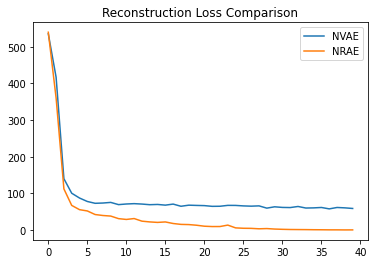

In [ ]:
plt.plot(losses_nvae, label='NVAE')
plt.plot(losses_nrae, label='NRAE')
plt.title('Reconstruction Loss Comparison')
plt.legend();

In [ ]:
from torchvision import transforms

def visualize(n_samples, model, logits, offset=0, size=(400, 400)):
  output = model.decoder_output(logits[offset:offset + n_samples])
  output_img = output.mean
  output_tiled = utils.tile_image(output_img, int(n_samples ** 0.5))

  transform = transforms.ToPILImage()
  img = transform(output_tiled)
  return img.resize(size)

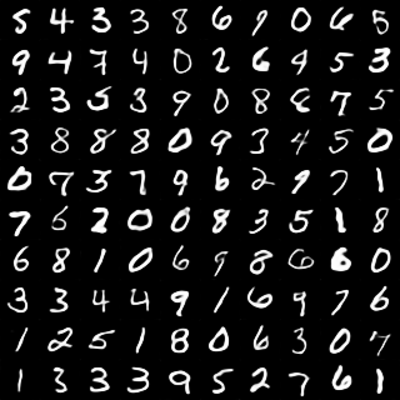

In [ ]:
# logits_sample_nvae = model.sample(100, 1)
visualize(100, model_nvae, logits_nvae)

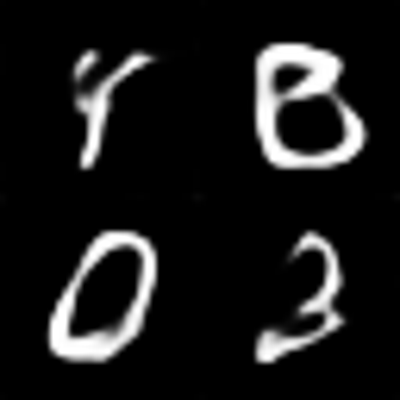

In [ ]:
logits_sample_nvae = model.sample(4, 1)
visualize(4, model, logits_sample_nvae)

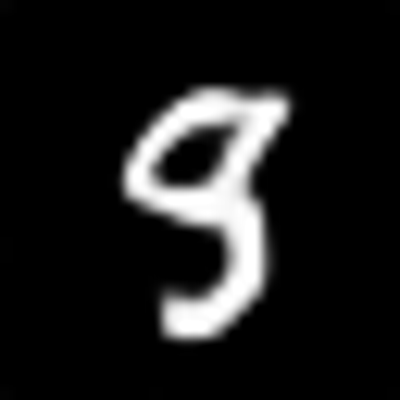

In [ ]:
logits_sample_nvae = model.sample(1, 1)
visualize(1, model, logits_sample_nvae)

In [ ]:
logits_sample_nvae

tensor([[[[ -4.1254,  -6.2175,  -6.4324,  ...,  -7.4641,  -7.0930,  -4.8001],
          [ -5.5438,  -8.6908,  -9.0458,  ..., -10.4357,  -9.9722,  -6.8681],
          [ -5.7541,  -8.9546,  -9.2756,  ..., -10.6525, -10.2726,  -7.1109],
          ...,
          [ -6.4782, -10.3199, -10.9319,  ..., -11.3035, -11.2339,  -7.9670],
          [ -6.8785, -10.8115, -11.2449,  ..., -11.3895, -11.1869,  -7.8669],
          [ -4.2513,  -6.8616,  -7.0899,  ...,  -7.1424,  -6.9864,  -5.1523]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [ ]:
print('mean: {:.4f} std: {:.4f}'.format(logits_sample_nvae.mean().item(), logits_sample_nvae.std().item()))

mean: -7.7058 std: 4.5167


# NRAE with XPDE

In [1]:
%cd NRAE

/content/NRAE


In [3]:
# Import libraries
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn import mixture
import os

import torch.distributed as dist
from torch.multiprocessing import Process
from torch.cuda.amp import autocast, GradScaler

from model import AutoEncoder
from thirdparty.adamax import Adamax
import utils
import datasets
from thirdparty.lsun import LSUN
from torchvision import transforms
import torchvision.datasets as dset

from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [4]:
# Get args
PATH = '/content/NRAE/eval-/checkpoint.pt'
checkpoint_nrae = torch.load(PATH)

# Get args
args_rae = checkpoint_nrae['args']

# Create Model
writer = utils.Writer(args_rae.global_rank, args_rae.save)
arch_instance = utils.get_arch_cells(args_rae.arch_instance)
model_nrae = AutoEncoder(args_rae, writer, arch_instance)
model_nrae = model_nrae.cuda()

# Load Model
model_nrae.load_state_dict(checkpoint_nrae['state_dict'])

# Get z0
z0_nrae = checkpoint_nrae['z0']

# Get logits
logits_nrae = checkpoint_nrae['logits']
logits_nrae.size()

MULT:  1.0
len log norm: 128
len bn: 92


torch.Size([200, 1, 32, 32])

In [5]:
# Initialize
os.environ['MASTER_ADDR'] = args_rae.master_address
os.environ['MASTER_PORT'] = '6020'
torch.cuda.set_device(args_rae.local_rank)
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=args_rae.num_process_per_node)

In [6]:
# def _data_transforms_lsun(size):
#     train_transform = transforms.Compose([
#         transforms.Resize(size),
#         transforms.RandomCrop(size),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ])

#     valid_transform = transforms.Compose([
#         transforms.Resize(size),
#         transforms.CenterCrop(size),
#         transforms.ToTensor(),
#     ])

#     return train_transform, valid_transform


def _data_transforms_mnist(args):
    """Get data transforms for cifar10."""
    train_transform = transforms.Compose([
        transforms.Pad(padding=2),
        transforms.ToTensor(),
        # Binarize(),
    ])

    valid_transform = transforms.Compose([
        transforms.Pad(padding=2),
        transforms.ToTensor(),
        # Binarize(),
    ])

    return train_transform, valid_transform

In [7]:
# from thirdparty.lsun import LSUN
# from torchvision import transforms

# # Preprocess data
# resize = 64
# num_classes = 1
# _, valid_transform = _data_transforms_lsun(resize)
# valid_data = LSUN(root='/content/NRAE', classes=['church_outdoor_val'], transform=valid_transform)
args_rae.data = '/content/NRAE'
num_classes = 10
train_transform, valid_transform = _data_transforms_mnist(args_rae)
train_data = dset.MNIST(
    root=args_rae.data, train=True, download=False, transform=train_transform)
valid_data = dset.MNIST(
    root=args_rae.data, train=False, download=False, transform=valid_transform)

In [8]:
train_sampler, valid_sampler = None, None

if args_rae.distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_data)
    valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_data)

train_queue = torch.utils.data.DataLoader(
        train_data, batch_size=args_rae.batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler, pin_memory=True, num_workers=8, drop_last=True)

valid_queue = torch.utils.data.DataLoader(
    valid_data, batch_size=args_rae.batch_size,
    shuffle=(valid_sampler is None),
    sampler=valid_sampler, pin_memory=True, num_workers=1, drop_last=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
def fit(model, queue, gmm):
  z = []
  with torch.no_grad():
    for x in queue:
      x = x[0].float().cuda()

      # Normalize x between -1, 1       
      s = model.stem(x)     
      
      # perform pre-processing         
      for cell in model.pre_process:   
          s = cell(s)                  
                                      
      # run the main encoder tower
      for cell in model.enc_tower:    
        if cell.cell_type != 'combiner_enc':
            s = cell(s)

      idx_dec = 0
      ftr = model.enc0(s)             
      z_ = model.enc_sampler[idx_dec](ftr) 
      z.append(z_)

  
  z = torch.cat(z)
  print('z:', z.shape)
  z = z.view(z.size(0), -1)
  gmm.fit(z.cpu().detach())
  
  return gmm, z

In [10]:
def sample(model, gmm, num_samples, z0=None):
  with torch.no_grad():
    scale_ind = 0
    
    z = z0  if z0 is not None else torch.tensor(gmm.sample(num_samples)[0]).view(num_samples, 20, 8, 8).cuda().float()

    idx_dec = 0
    s = model.prior_ftr0.unsqueeze(0)
    batch_size = z.size(0)
    s = s.expand(batch_size, -1, -1, -1)
    for cell in model.dec_tower:
        if cell.cell_type == 'combiner_dec':
            if idx_dec > 0:
                # form prior
                z = model.dec_sampler[idx_dec - 1](s)
                # mu, log_sigma = torch.chunk(param, 2, dim=1)
                # dist = Normal(mu, log_sigma, t)
                # z, _ = dist.sample()

            # 'combiner_dec'
            s = cell(s, z)
            idx_dec += 1
        else:
            s = cell(s)
            if cell.cell_type == 'up_dec':
                scale_ind += 1

    for cell in model.post_process:
        s = cell(s)

    logits = model.image_conditional(s)
  return logits

In [11]:
def visualize(n_samples, model, logits, title='', offset=0, size=(8, 8)):
  output = logits[offset:offset + n_samples]
  output_img = output
  output_tiled = utils.tile_image(output_img, int(n_samples ** 0.5)).squeeze(0).float()
  
  plt.rcParams["figure.figsize"] = size
  plt.axis('off')
  plt.imshow(output_tiled.detach().cpu().numpy(),cmap='gray')
  

In [21]:
gmm = mixture.GaussianMixture(
            n_components=50,
            covariance_type="full",
            max_iter=2000,
            verbose=2,
            tol=1e-3,
        )

In [22]:
gmm, z_enc = fit(model_nrae, valid_queue, gmm)

z: torch.Size([10000, 20, 8, 8])
Initialization 0
Initialization converged: True	 time lapse 254.98989s	 ll 6243.35480


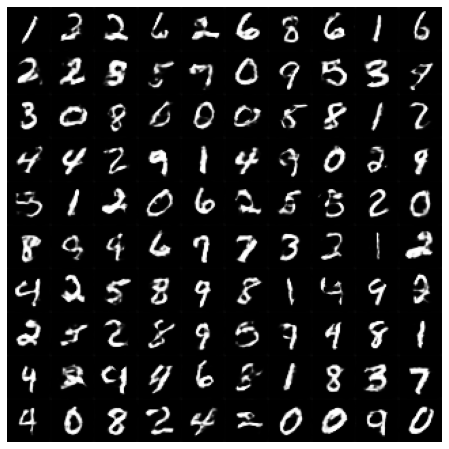

In [24]:
# 4 epoch prev
logit_nrae_sampled = sample(model_nrae, gmm, 100, None)
idx = torch.randperm(100)
logit = logit_nrae_sampled[idx]
visualize(100, model_nrae, logit)

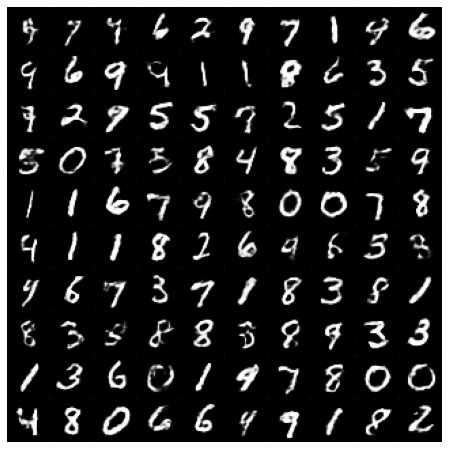

In [25]:
# 4 epoch prev
logit_nrae_sampled = sample(model_nrae, gmm, 100, None)
idx = torch.randperm(100)
logit = logit_nrae_sampled[idx]
visualize(100, model_nrae, logit)

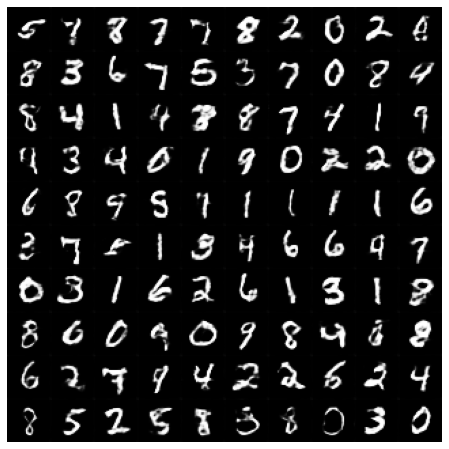

In [26]:
# 4 epoch prev
logit_nrae_sampled = sample(model_nrae, gmm, 100, None)
idx = torch.randperm(100)
logit = logit_nrae_sampled[idx]
visualize(100, model_nrae, logit)

In [27]:
# 4 epoch prev
logit_nrae_sampled = sample(model_nrae, gmm, 100, None)
idx = torch.randperm(100)
logit = logit_nrae_sampled[idx]
visualize(100, model_nrae, logit)

KeyboardInterrupt: ignored

In [ ]:
# 4 epoch prev
logit_nrae_sampled = sample(model_nrae, gmm, 100, None)
idx = torch.randperm(100)
logit = logit_nrae_sampled[idx]
visualize(100, model_nrae, logit)

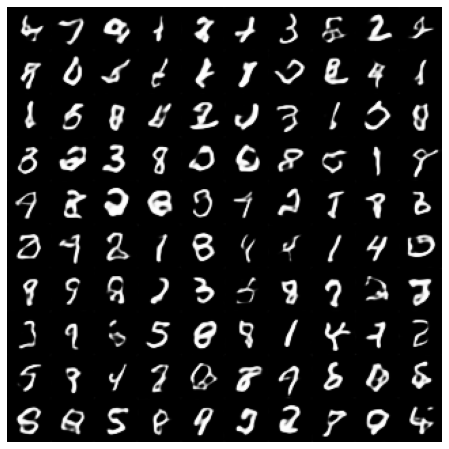

In [ ]:
# NVAE Samples
logit_nvae_sampled = model_nvae.sample(100, 1)
logits = model_nvae.decoder_output(logit_nvae_sampled).mean
visualize(100, model_nvae, logits)

In [28]:
xpde = gmm.sample(2000)[0]
latent_xpde = TSNE(n_components=2, learning_rate='auto', perplexity=10,
                   init='pca').fit_transform(xpde)

nrae = z_enc[:2000].cpu().detach()
latent_nrae = TSNE(n_components=2, learning_rate='auto', perplexity=15,
                   init='pca').fit_transform(nrae)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


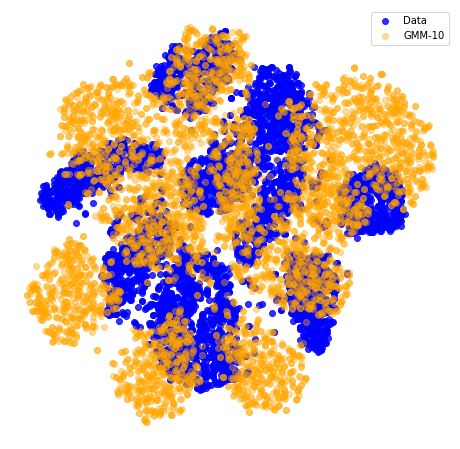

In [22]:
# embedding weght: 1e-2 
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.scatter(latent_nrae[:, 0], latent_nrae[:, 1], color='blue',   alpha=0.8, label='Data')
plt.scatter(latent_xpde[:, 0], latent_xpde[:, 1], color='orange', alpha=0.4, label='GMM-10')


plt.legend();

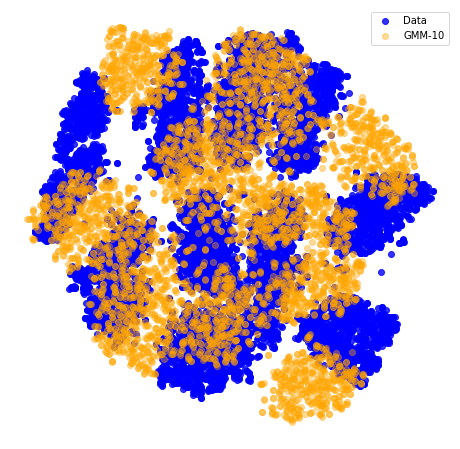

In [24]:
# embedding weght: 1e-2 
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.scatter(latent_nrae[:, 0], latent_nrae[:, 1], color='blue',   alpha=0.8, label='Data')
plt.scatter(latent_xpde[:, 0], latent_xpde[:, 1], color='orange', alpha=0.4, label='GMM-10')


plt.legend();

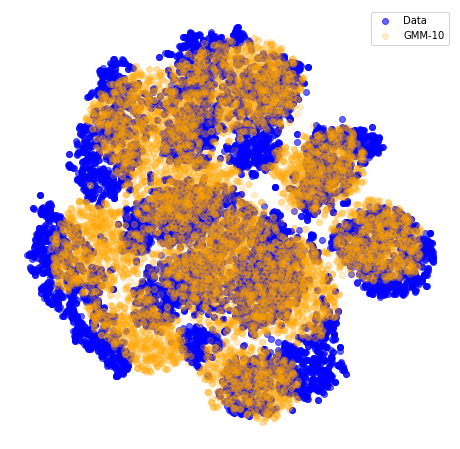

In [41]:
# embedding weght: 1e-2 
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.scatter(latent_nrae[:, 0], latent_nrae[:, 1], color='blue',   alpha=0.6, label='Data')
plt.scatter(latent_xpde[:, 0], latent_xpde[:, 1], color='orange', alpha=0.2, label='GMM-10')


plt.legend();

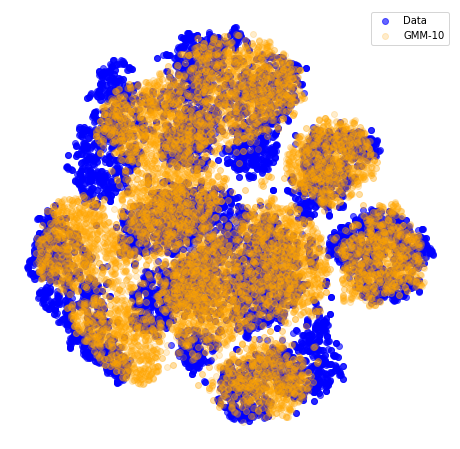

In [43]:
# embedding weght: 1e-2 
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.scatter(latent_nrae[:, 0], latent_nrae[:, 1], color='blue',   alpha=0.6, label='Data')
plt.scatter(latent_xpde[:, 0], latent_xpde[:, 1], color='orange', alpha=0.2, label='GMM-10')


plt.legend();

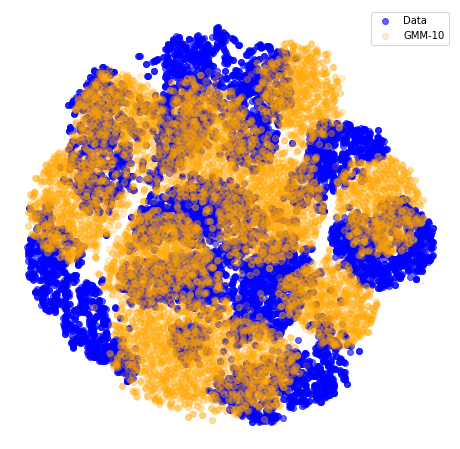

In [20]:
# embedding weght: 1e-2 
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.scatter(latent_nrae[:, 0], latent_nrae[:, 1], color='blue',   alpha=0.6, label='Data')
plt.scatter(latent_xpde[:, 0], latent_xpde[:, 1], color='orange', alpha=0.2, label='GMM-10')


plt.legend();

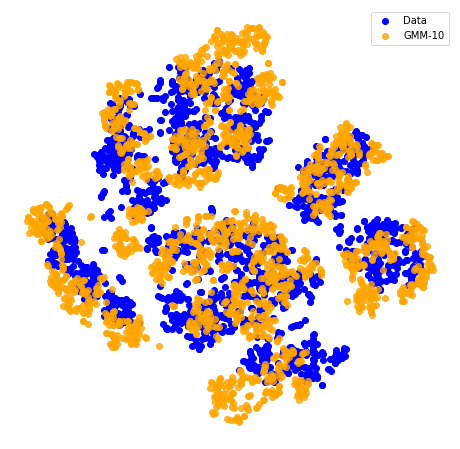

In [30]:
# embedding weght: 1e-2 
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.scatter(latent_nrae[:, 0], latent_nrae[:, 1], color='blue',   alpha=1, label='Data')
plt.scatter(latent_xpde[:, 0], latent_xpde[:, 1], color='orange', alpha=0.8, label='GMM-10')


plt.legend();